# Table of Contents
 <p>

In [124]:
import pandas as pd
import numpy as np
import scipy as scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [125]:
x = np.random.normal(1, .5, 10)
y = np.random.standard_t(2.7, 10) - .5

y[0:2] = np.random.normal(2, 1, 2)

# place the data in a dataframe
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy the dataframe, so each row is 1 observation
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')

tidy.head()

,genotype,expression
0,wt,1.164222
1,wt,0.696737
2,wt,0.605764
3,wt,0.909688
4,wt,0.992022


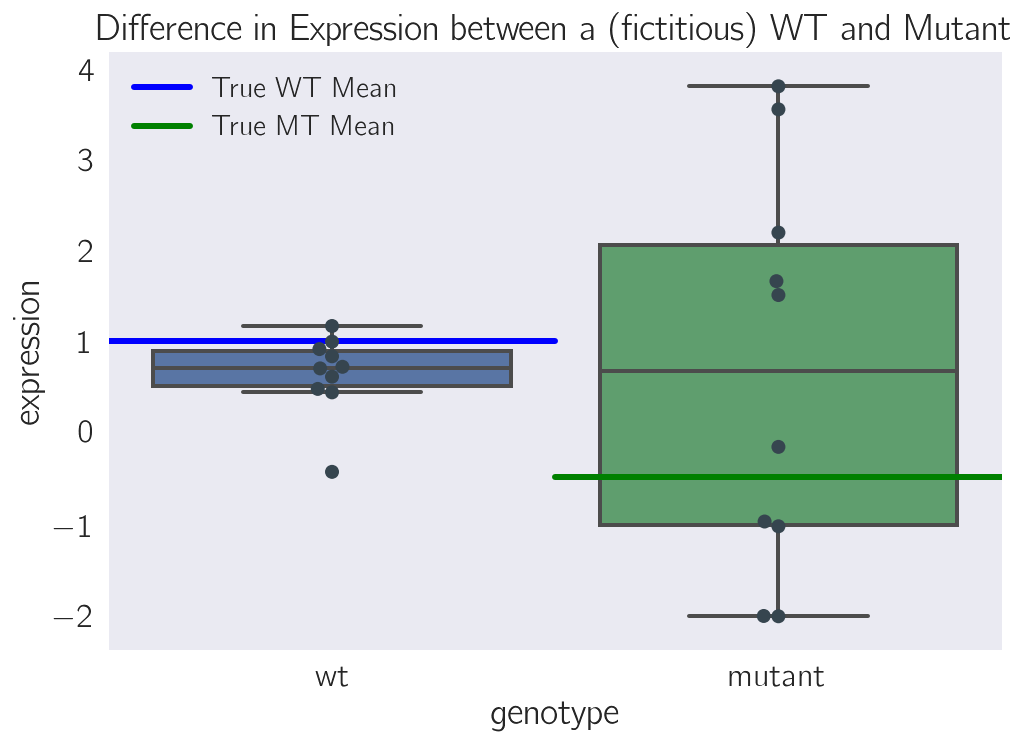

In [126]:
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')
plt.gca().axhline(1, xmin=0, xmax=0.5, color='blue', label='True WT Mean', lw=3)
plt.gca().axhline(-0.5, xmin=0.5, xmax=1, color='green', label='True MT Mean', lw=3)
plt.legend()
plt.title('Difference in Expression between a (fictitious) WT and Mutant')

In [127]:
def non_parametric_bootstrap(x, f, nsim=1000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))
        
        statistic[i] = f(X, **kwargs)
    
    return statistic

In [128]:
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values

scipy.stats.mannwhitneyu(wt, mt)

MannwhitneyuResult(statistic=49.0, pvalue=0.48492498849657778)

In [129]:
meanx = non_parametric_bootstrap(wt, np.mean)
meany = non_parametric_bootstrap(mt, np.mean)

def mann_whitneyu(wt, mt):
    return scipy.stats.mannwhitneyu(wt, mt)[1]

pvals = non_parametric_bootstrap_statistic(wt, mt, mann_whitneyu)

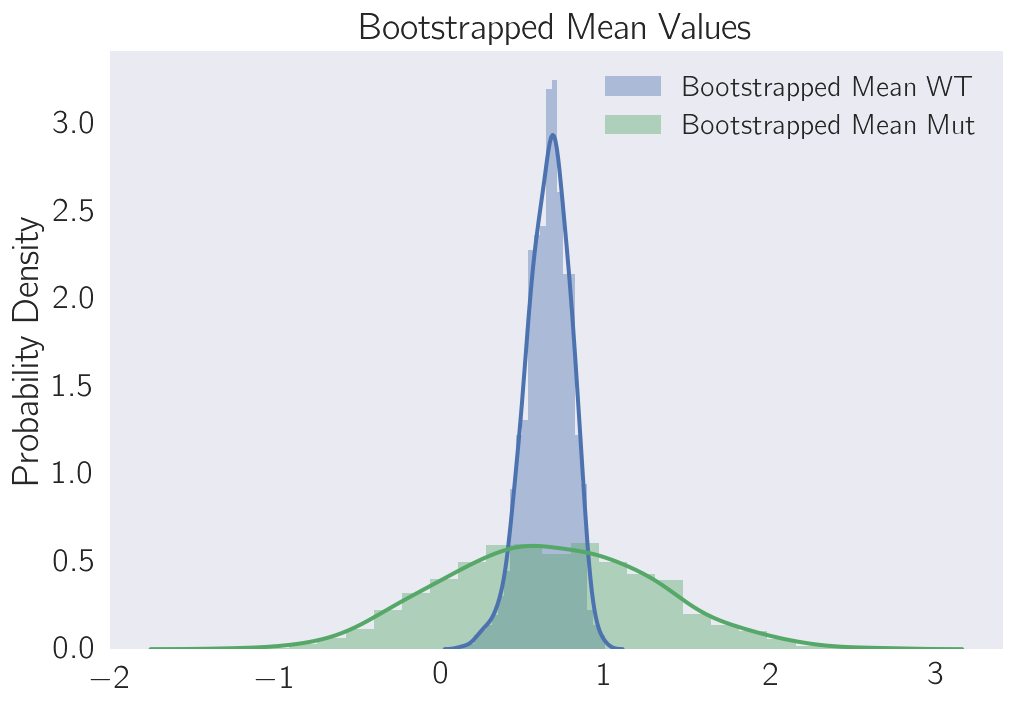

In [130]:
sns.distplot(meanx, label='Bootstrapped Mean WT')
sns.distplot(meany, label='Bootstrapped Mean Mut')
# plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
# plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
# plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped Mean Values')
plt.legend()

In [131]:
def difference_of_means(x, y):
    return np.mean(y) - np.mean(x)

def test_null(x, y, statistic, iters=1000):
    """
    Given two datasets, test a null hypothesis using a permutation test for a given statistic.
    
    Params:
    x, y -- ndarrays, the data
    statistic -- a function of x and y
    iters -- number of times to bootstrap
    
    Ouput:
    a numpy array containing the bootstrapped statistic
    """
    def permute(x, y):
        """Given two datasets, return randomly shuffled versions of them"""
        # concatenate the data
        new = np.concatenate([x, y])
        # shuffle the data
        np.random.shuffle(new)
        # return the permuted data sets:
        return new[:len(x)], new[len(x):]

    # do the bootstrap
    return np.array([statistic(*permute(x, y)) for _ in range(iters)])
    
diff = test_null(wt, mt, difference_of_means, iters=10**5)

The p-value for these samples is 0.5
We cannot reject the null hypothesis that the means are equal between both samples


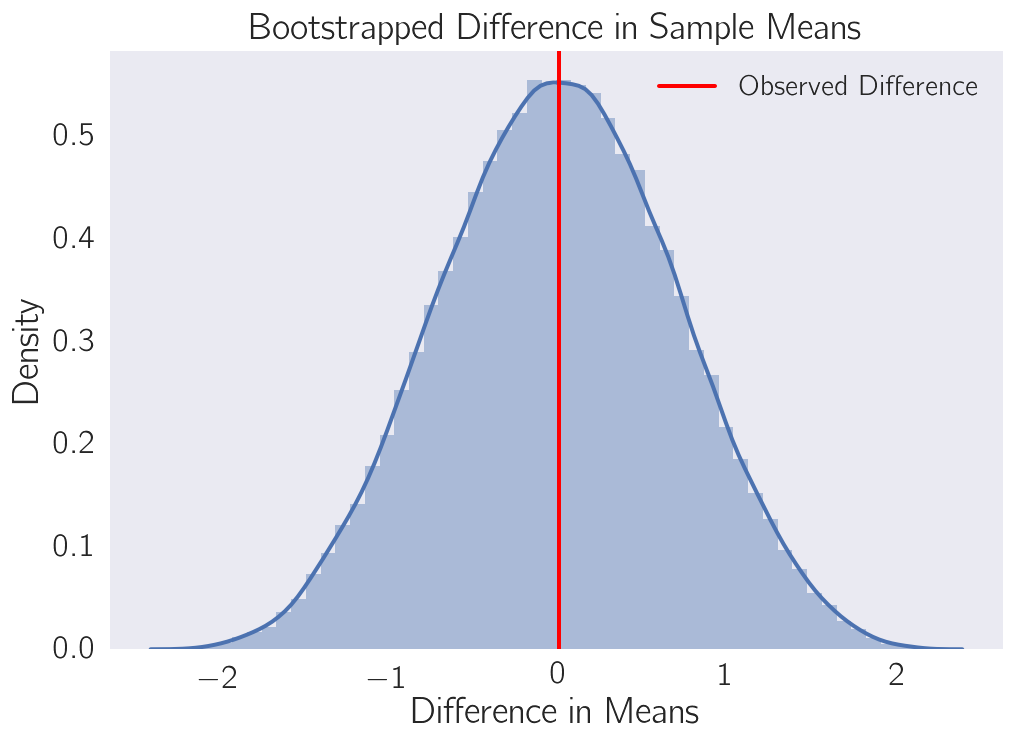

In [132]:
sns.distplot(diff)
plt.axvline(mt.mean() - wt.mean(), color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Means')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff[diff < mt.mean() - wt.mean()])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

In [133]:
def difference_of_variance(x, y):
    
    return np.std(y)**2 - np.std(x)**2


diff_vars = test_null(wt - wt.mean(), mt - mt.mean(), difference_of_variance, iters=10**5)

The p-value for these samples is 1e-05
We can reject the null hypothesis that the means are equal between both samples


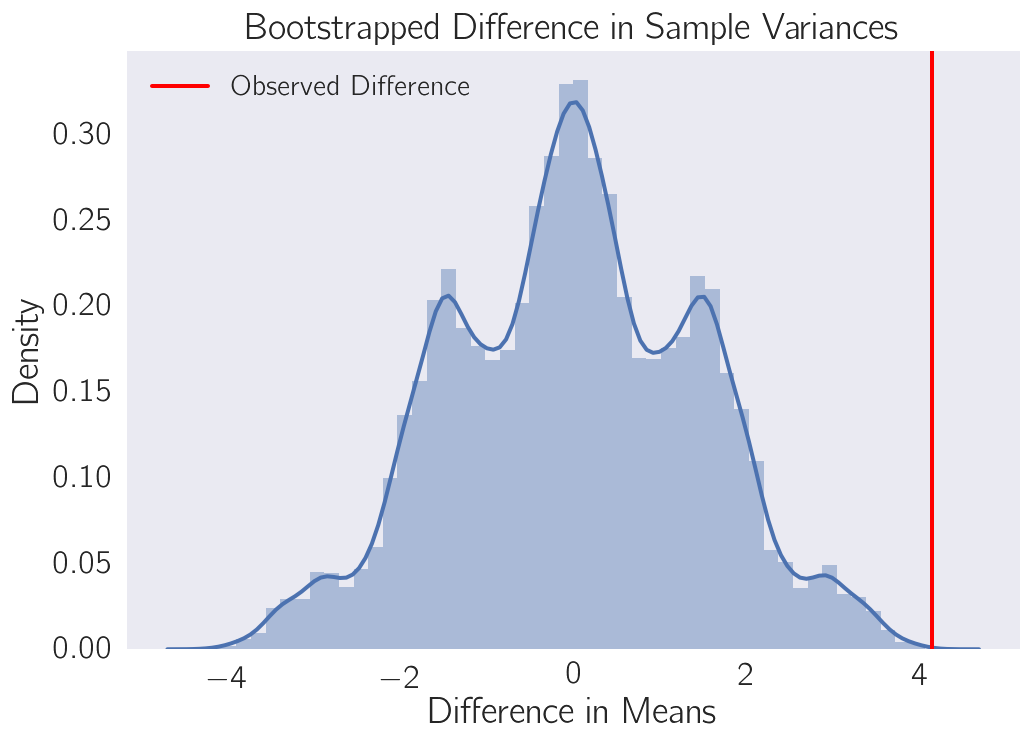

In [134]:
sns.distplot(diff_vars)
plt.axvline(mt.std()**2 - wt.std()**2, color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Variances')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff_vars[diff_vars > mt.std()**2 - wt.std()**2])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

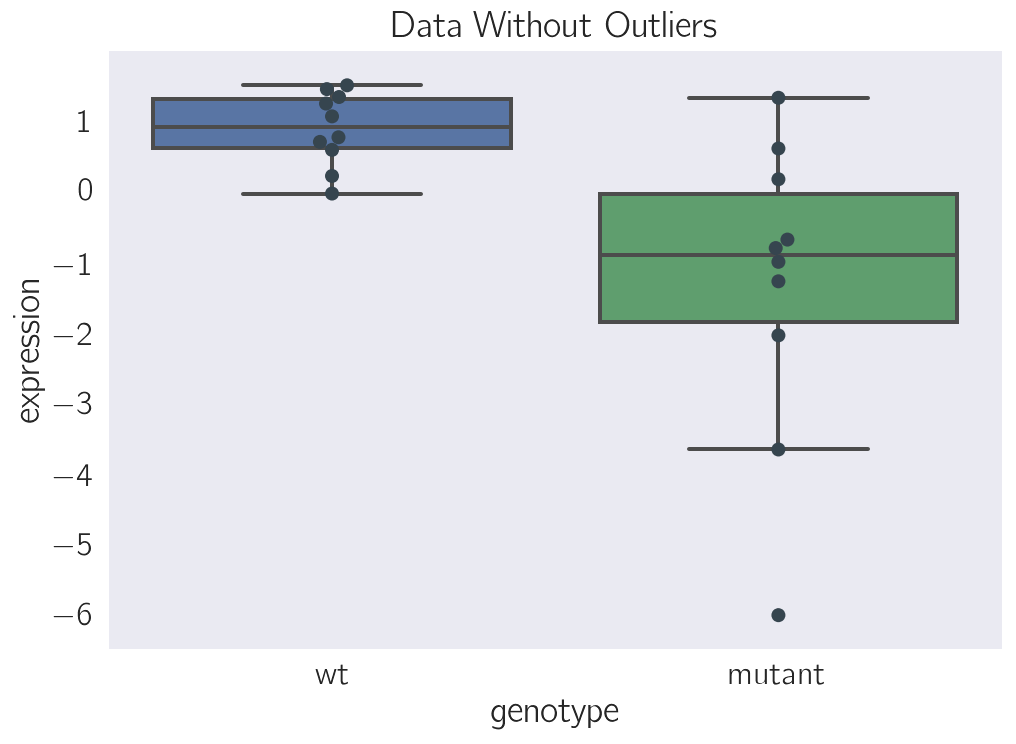

In [135]:
x = np.random.normal(1, .5, 10)
y= np.random.standard_t(2.7, 10) - 1

data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy:
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')

plt.title('Data Without Outliers')

In [136]:
diff = test_null(wt, mt, difference_of_means, iters=10**5)

pvalue = len(diff[diff > mt.std()**2 - wt.std()**2])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

The p-value for these samples is 0
We can reject the null hypothesis that the means are equal between both samples


In [137]:
diff_vars = test_null(wt - wt.mean(), mt - mt.mean(), difference_of_variance, iters=10**5)
pvalue = len(diff_vars[diff_vars > mt.std()**2 - wt.std()**2])/len(diff_vars)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

The p-value for these samples is 1e-05
We can reject the null hypothesis that the means are equal between both samples
